In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'D:\\3term\\DANA 4830\\study_4830\\utils.py'>

In [63]:
df = pd.read_csv('data.csv').drop(columns = 'ID', axis=1)
df = df.dropna(axis=0, how='any')
X = df.drop(columns = 'class', axis =1 )
y = df['class']
df.head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [64]:
int_columns, float_columns, object_columns, numerical_columns = utils.columns_df(X)

Shape: (174, 450)
Numerical features:  450
Categorical features:  0


In [65]:
X_v = pd.DataFrame()

In [66]:
for r in range(X.shape[0]):
    row = X.iloc[r,:]
    features = {}
    for i in range(25):
        task = 'task_' + str(i+1)
        i_vector = []
        lim_inf = i*18
        lim_sup = i*18+17
        features[task] = np.array(row[lim_inf:lim_sup+1])
    row_df = pd.DataFrame([features])
    X_v = pd.concat([X_v, row_df], ignore_index=True)

In [67]:
X_v.shape

(174, 25)

# Train and test dataset split

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_v, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(139, 25) (139,)
(35, 25) (35,)


In [69]:
X_train.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10,...,task_16,task_17,task_18,task_19,task_20,task_21,task_22,task_23,task_24,task_25
42,"[1370.0, 7.07e-06, 377.251255, 322.5462303, 17...","[2710.0, 1.32e-05, 83.96809011, 42.74393577, 3...","[1700.0, 1.21e-05, 490.4374907, 93.64138135, 4...","[1160.0, 2.59e-05, 95.94045772, 51.42006897, 4...","[1295.0, 1.54e-05, 103.2043045, 42.77134201, 2...","[4775.0, 4.57e-06, 259.5367867, 228.2726614, 2...","[3835.0, 3.77e-06, 331.3635259, 496.7711039, 1...","[720.0, 7.68e-06, 270.9842092, 69.18376072, 12...","[5700.0, 1.75e-05, 826.8067406, 293.9447469, 5...","[1540.0, 5.56e-06, 127.6119461, 96.12304006, 1...",...,"[1370.0, 3.08e-06, 208.2082876, 140.8660316, 5...","[15980.0, 2.52e-05, 252.4572889, 257.4636898, ...","[2485.0, 3.09e-06, 239.9779665, 163.4691553, 6...","[64950.0, 2.83e-05, 105.7435171, 114.5366777, ...","[17435.0, 1.88e-05, 114.8562622, 98.14731529, ...","[11560.0, 3.91e-05, 301.4007307, 132.7845252, ...","[4800.0, 7.79e-06, 220.5717081, 354.7362697, 1...","[3155.0, 9.9e-06, 222.5410025, 311.3174718, 14...","[33485.0, 3.82e-05, 136.1571771, 153.7172176, ...","[75705.0, 7.27e-05, 143.4178799, 124.1078141, ..."
159,"[2725.0, 9.87e-06, 511.5339367, 222.3048626, 1...","[6055.0, 7.41e-06, 328.5165445, 283.5935654, 7...","[1080.0, 4.62e-06, 166.2400745, 216.9221694, 4...","[4580.0, 2.54e-05, 526.390428, 84.48220575, 41...","[595.0, 1.53e-05, 112.4472315, 60.17624509, 24...","[9670.0, 5.35e-06, 235.4374334, 127.2337255, 1...","[7890.0, 6.13e-06, 450.8964968, 301.2244236, 1...","[850.0, 6.3e-06, 251.7176198, 90.92441416, 101...","[3685.0, 9.63e-06, 427.9348411, 83.43339083, 1...","[1645.0, 7.19e-06, 136.4537822, 114.9459196, 1...",...,"[4550.0, 4.63e-06, 142.6328697, 95.83141247, 6...","[20585.0, 2.58e-05, 220.7718572, 321.6450364, ...","[3250.0, 5.09e-06, 97.53383978, 90.41639153, 7...","[47170.0, 3.46e-05, 144.7426116, 172.4801394, ...","[10175.0, 1.76e-05, 196.7413326, 100.5254108, ...","[8925.0, 5.97e-05, 424.8076308, 100.4576432, 9...","[4690.0, 9.29e-06, 165.1428839, 135.5123804, 1...","[5580.0, 9.89e-06, 155.7979056, 150.1733495, 1...","[21100.0, 1.73e-05, 106.584382, 68.27503882, 3...","[48705.0, 6.53e-05, 209.1131747, 151.057805, 7..."
36,"[12960.0, 1.86e-05, 154.0948756, 66.1379203, 1...","[15325.0, 1.4e-05, 175.2733485, 54.26261489, 8...","[5730.0, 1.34e-05, 311.9966895, 62.15459016, 4...","[4535.0, 2.9e-05, 180.1251962, 57.38809844, 50...","[3810.0, 1.06e-05, 193.6641898, 91.21943132, 2...","[24640.0, 9.95e-06, 182.4952323, 60.8460517, 1...","[18800.0, 4.42e-06, 127.2472551, 344.7586886, ...","[14075.0, 1.37e-05, 94.8257617, 57.94670637, 2...","[1305.0, 1.14e-05, 274.328988, 90.20171874, 20...","[700.0, 4.77e-06, 247.2149235, 140.5013861, 19...",...,"[6935.0, 3.08e-06, 100.2393465, 118.5579806, 4...","[294615.0, 2.58e-05, 438.8301005, 250.3363093,...","[15195.0, 3.03e-06, 132.0302772, 120.2030409, ...","[46695.0, 3.17e-05, 98.80639833, 189.768551, 7...","[11935.0, 1.93e-05, 157.1455338, 166.4011123, ...","[8760.0, 4.92e-05, 457.0253441, 107.2885584, 9...","[4675.0, 8.01e-06, 146.9493, 187.0168294, 1091...","[7350.0, 9.81e-06, 188.155808, 155.456445, 194...","[12320.0, 1.34e-05, 138.5852813, 111.6585556, ...","[63535.0, 4.76e-05, 257.4979401, 197.8631328, ..."
20,"[3525.0, 1.02e-05, 126.3235989, 139.5962431, 1...","[21475.0, 1.39e-05, 281.4527552, 71.43766562, ...","[6050.0, 1.25e-05, 279.3072557, 101.0769784, 4...","[3360.0, 2.17e-05, 88.2764213, 41.47304451, 35...","[1305.0, 1.47e-05, 49.12801229, 54.55355305, 2...","[9700.0, 6.27e-06, 369.8496925, 264.4192541, 9...","[16275.0, 7.42e-06, 126.6574219, 252.4533088, ...","[1645.0, 6.35e-06, 216.1778698, 126.2798567, 1...","[2430.0, 8.49e-06, 70.13615292, 39.58217104, 1...","[32385.0, 9.12e-06, 46.60663172, 65.34455374, ...",...,"[7980.0, 5.32e-06, 32.02340682, 60.23092413, 6...","[113160.0, 3.49e-05, 68.59808208, 91.39886692,...","[14365.0, 7.72e-06, 26.78329827, 77.15468405, ...","[30540.0, 2.9e-05,

# Decision Tree classifier

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
models = {}
for i in range(25):
    row = {}
    row['task'] = i+1
    
    row['label'] = 'Model_DTree_'+str(i+1)
    
    column = 'task_'+str(i+1)
    train =  X_train[column]
    train_df = pd.DataFrame(train.tolist(), index = train.index)
    test = X_test[column]
    test_df = pd.DataFrame(test.tolist(), index = test.index)
    
    clf = DecisionTreeClassifier()
    clf.fit(train_df, y_train)
    y_pred = clf.predict(test_df)
    row['model'] = clf
    row['train'] = train_df
    row['test'] = test_df
    row['pred'] = y_pred
    row['accuracy'] = accuracy_score(y_test, y_pred)
    models[i+1]= row

In [71]:
models_df = pd.DataFrame(models).transpose()
#models_df.set_index('id', inplace=True)
models_df.head()

,task,label,model,train,test,pred,accuracy
1,1,Model_DTree_1,DecisionTreeClassifier(),0 1 2 3 ...,0 1 2 3...,"[H, H, H, P, P, P, H, H, H, P, P, H, P, P, P, ...",0.657143
2,2,Model_DTree_2,DecisionTreeClassifier(),0 1 2 3 ...,0 1 2 3 ...,"[H, P, P, P, P, P, H, H, H, P, H, H, H, H, P, ...",0.685714
3,3,Model_DTree_3,DecisionTreeClassifier(),0 1 2 3 ...,0 1 2 3 ...,"[P, P, H, P, H, H, P, P, H, H, H, P, H, H, H, ...",0.6
4,4,Model_DTree_4,DecisionTreeClassifier(),0 1 2 3 ...,0 1 2 3 ...,"[H, H, H, P, H, P, P, P, H, P, P, P, H, P, H, ...",0.628571
5,5,Model_DTree_5,DecisionTreeClassifier(),0 1 2 3 ...,0 1 2 3 ...,"[H, H, H, P, P, P, P, H, H, P, P, H, H, P, H, ...",0.657143


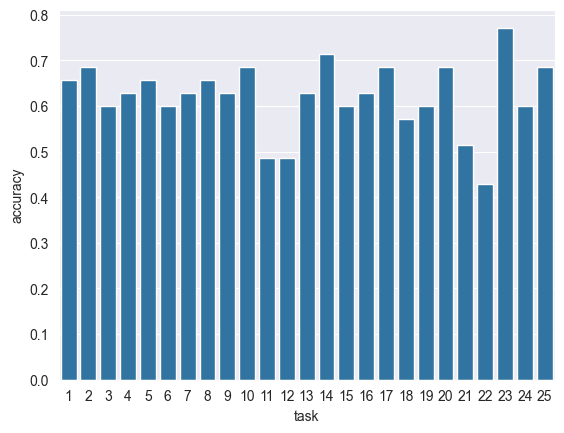

In [72]:
sns.barplot(x='task', y='accuracy', data=models_df)
plt.show()